# CSC311 Lab 4: Logistic Regression and the Analyses of Errors

In this lab, we will continue working with the NHANES dataset. In a prior lab,
we explored features in this dataset and worked to build a decision tree classifier
that would maximize accuracy. In this lab we will look more closely at
classification mistakes by exploring how they are distributed across
important subgroups. We will also consider how assessments of risk
that are associated with our errors should or could inform our
decision making criteria. Our discussions will be related to a
logistic regression classifier, but we could just as well do much
of this work with other kinds of classifiers as well.

By the end of this lab you will be able to:

1. Implement a logistic regression model using stochastic gradient descent.
2. State and explain numerical and gradient signal issues related to implementing the logistic loss.
3. Implement a logistic regression model using `sklearn`.
4. Analyze various evaluation metrics to understand model performance beyond accuracy.
5. Explore your model's decision making errors.
6. Relate errors to important subgroups.
7. Tailor your decision making criteria to balance decision making risks across subgroups.

Please work in groups of 1-2 during the labs.

Acknowledgements:

- Thanks to https://www.kaggle.com/code/tobyanderson/health-survey-analysis for some utilities to decode NHANES categories!  
- This lab was created in collaboration with, Prof. Sonya Allin, Mustafa Haiderbhai, Carolyn Quinlan, Brandon Jaipersaud and others.

## Submission

If you are working with a partner, start by creating a group on Markus. If you are working alone,
click "Working Alone".

Submit the ipynb file `lab05.ipynb` on Markus
**containing all your solutions to the Graded Tasks**.
Your notebook file must contain your code **and outputs** where applicable,
including printed lines and images.
Your TA will not run your code for the purpose of grading.

For this lab, you should submit the following:

- Part 2. Your implementation of `pred`, `loss`, and `grad` functions. (4 point)
- Part 3. Your implementation of the `solve_via_sgd` grad functions. (2 point)
- Part 3. Your implementation and explanation of the time difference between stochastic and full batch gradient descent (2 point)
- Part 5. Your visualization of the confusion matrix for men and women. (1 point)
- Part 5. Your interpretation of the differences in the confusion matrix for men and women. (1 point)

## Google Colab Setup

As before, we will import `matplotlib` and `numpy` for plotting and linear algebra
manipulations.

In [1]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # Linear algebra library
import pandas as pd             # For manipulating tabular data

## Part 1. Data

Like in lab 2, we will use the NHANES data set.
We again refer you to the [NHANES data dictionary](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx)
to better understand the data.
We will not repeat the exploratory data analysis from lab 2, but encourage
you to review the data definition and key summary.

- `gender` (RIAGENDR): which is binary 2=female, 1=male
- `race_ethnicity` (RIDRETH3): which can be 1=mexican american, 2=other hispanic, 3=white, 4=black, 6=asian, ...
- `age` (RIDAGEYR): Age in years
- `drink_alcohol` (ALQ101): which is binary; 1 indicates the individual reportedly drinks alcohol and 2 indicates they do not
- `blood_cholesterol` (LBDTCSI): Results of an individual's blood cholesterol tests (mmol of cholesterol/L of blood)
- `blood_pressure_sys` (BPXSY1): an individual's systolic blood pressure
- `diastolic_bp` (BPXDI1): an individual's diastolic blood pressure
- `calories` (DR1TKCAL): the number of calories an individual eats per day
- `BMI` (BMXBMI): an individual's Body Mass Index (which can be used to assess obesity)
- `chest_pain_ever` (CDQ001): If an individual has ever reported chest pain.
- `family_income` (INDFMPIR): Ratio of a family's income to poverty threshold

We will be using these features to predict the column `target_heart`:

- `target_heart`: An individual reports that they have heart disease (1=yes, 0=no).

In [4]:
!wget https://www.cs.toronto.edu/~lczhang/311/lab02/NHANES-heart.csv

--2025-02-01 01:26:08--  https://www.cs.toronto.edu/~lczhang/311/lab02/NHANES-heart.csv
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 450659 (440K) [text/csv]
Saving to: ‘NHANES-heart.csv’

NHANES-heart.csv    100%[===================>] 440.10K  --.-KB/s    in 0.1s    

2025-02-01 01:26:08 (3.74 MB/s) - ‘NHANES-heart.csv’ saved [450659/450659]



In [5]:
# read a csv file as a *pandas data frame*
data = pd.read_csv("NHANES-heart.csv")

# display a dataframe
data.describe()

,gender,race_ethnicity,chest_pain_ever,drink_alcohol,age,BMI,weight_kg,blood_pressure_sys,diastolic_bp,blood_cholesterol,calories,family_income,target_heart
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,1.498375,3.222000,1.649125,1.304375,62.627875,25.352687,61.112887,117.135500,65.705000,4.584376,1866.986875,2.456017,0.500000
std,0.500029,1.330672,0.477274,0.460171,12.225806,7.683466,32.803242,15.050115,11.610893,0.908403,867.494312,1.532800,0.500031
min,1.000000,1.000000,1.000000,1.000000,40.000000,12.900000,3.300000,82.000000,0.000000,2.020000,171.000000,0.000000,0.000000
25%,1.000000,3.000000,1.000000,1.000000,52.000000,19.700000,33.600000,108.000000,60.000000,4.090000,1337.750000,1.180000,0.000000
50%,1.000000,3.000000,2.000000,1.000000,63.000000,24.600000,63.700000,116.000000,66.000000,4.500000,1735.000000,2.050000,0.500000
75%,2.000000,4.000000,2.000000,2.000000,73.000000,29.500000,83.000000,122.000000,72.000000,4.970000,2215.250000,3.800000,1.000000
max,2.000000,7.000000,2.000000,2.000000,80.000000,82.900000,201.600000,220.000000,116.000000,11.970000,8496.000000,5.000000,1.000000


As a quick review, we can visualize the spread of numerical features using box plots,
and tabulate the frequency of each category for categorical features.

gender           1     2
target_heart            
0.0           1819  2181
1.0           2194  1806
drink_alcohol   1.0   2.0
target_heart             
0.0            2824  1176
1.0            2741  1259
chest_pain_ever   1.0   2.0
target_heart               
0.0               791  3209
1.0              2016  1984
race_ethnicity    1    2     3    4    6   7
target_heart                                
0.0             561  385  1773  768  449  64
1.0             362  264  2217  828  244  85


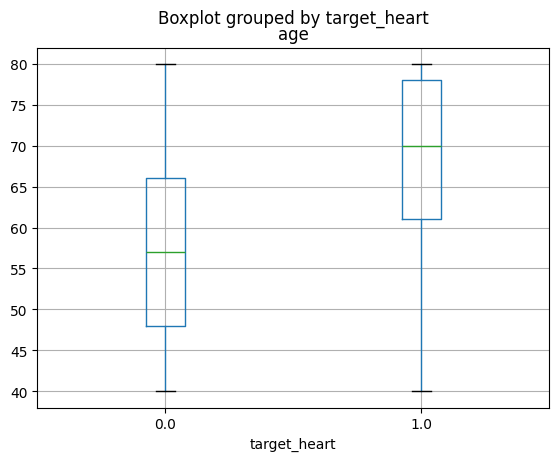

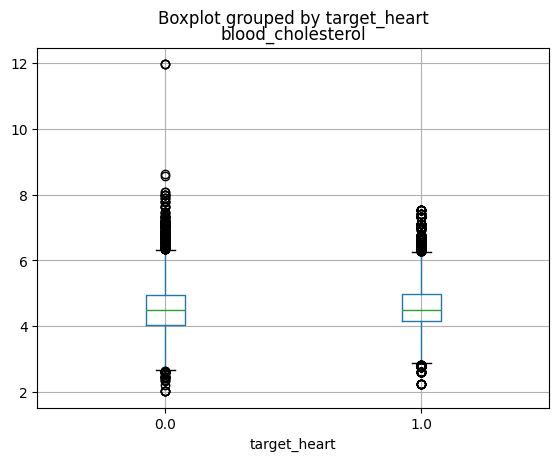

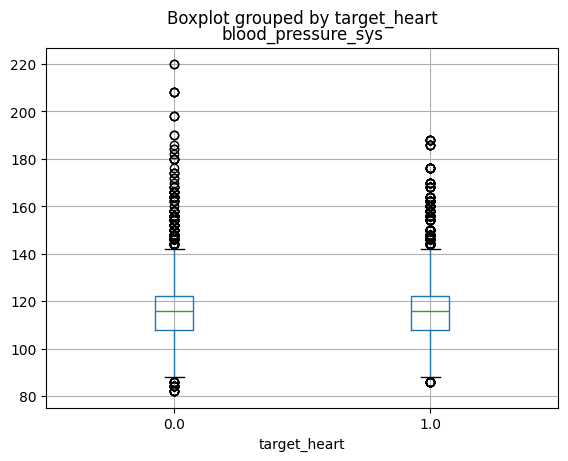

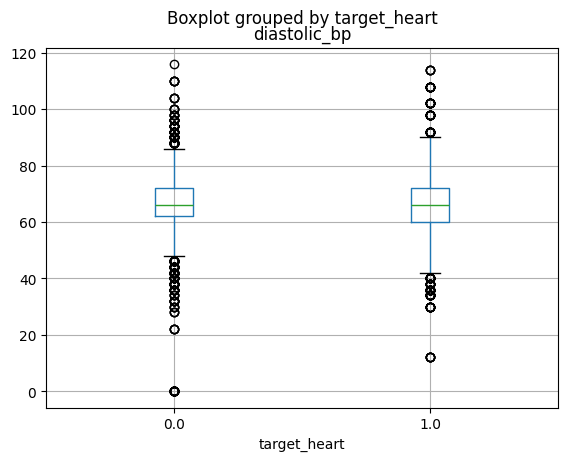

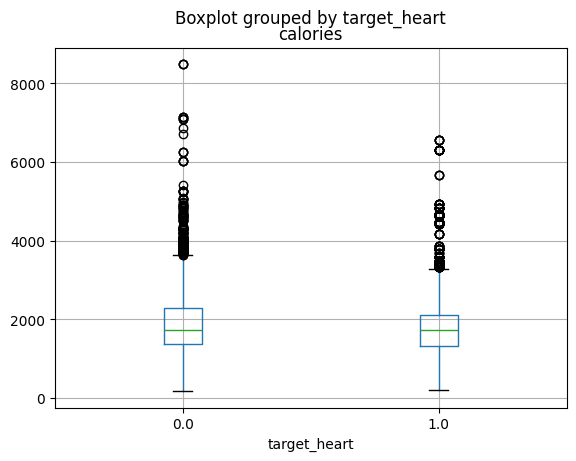

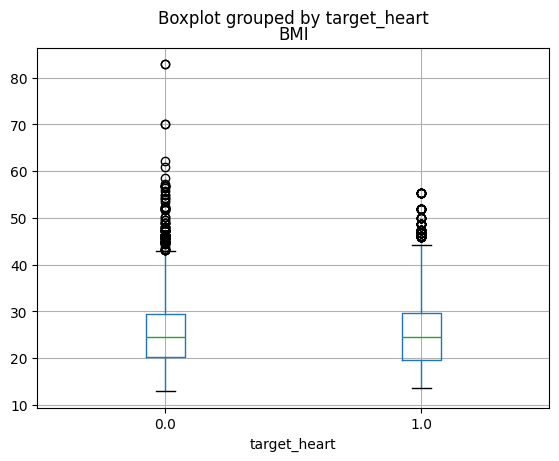

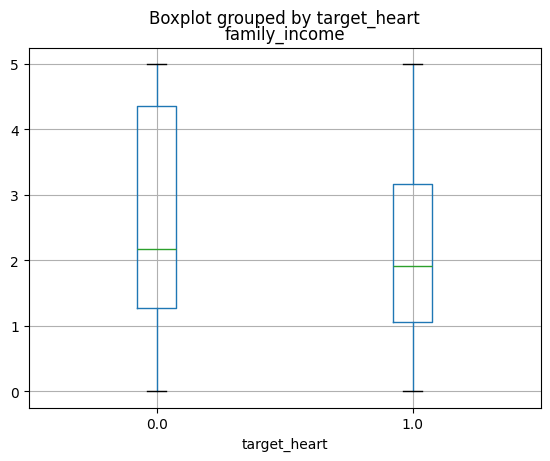

In [6]:
for fet in ["age", "blood_cholesterol", "blood_pressure_sys",
            "diastolic_bp", "calories", "BMI", "family_income"]:
    data.boxplot(column=fet, by='target_heart')

for fet in ["gender", "drink_alcohol", "chest_pain_ever", "race_ethnicity"]:
    print(pd.crosstab(data["target_heart"], data[fet]))

Recall, again, that the distribution of our target variable has been balanced.
This is absolutely **NOT** representative of the distribution of heart disease
in the general population.  In the general population of  Canada, about 1 in 12 (or 8%) have heart disease.  This is roughly the same as the distribution of reported heart disease across all NHANES survey respondents.

We balanced the data so that the model we built is not biased towards one class.
For example, if 92% of the training samples belong to one class, then a model that predicts
the majority class will obtain 92% accuracy! Such a simple model may represent a local minima in our optimization landscape, making it challenging to find the parameters a better model.

In [7]:
data['target_heart'].value_counts() # notice the data has been balanced

,count
target_heart,
0.0,4000
1.0,4000


Like in lab 2, we will use indicator features for categorical values
You should be able to understand why is this as important in a logistic regression model as it was with our decision tree. Unlike  lab 2, we will add a column of entirely ones to our feature vectors. The reason for this was discussed
in our lecture and is for mathematical convenience; it allows us to include a scalar bias parameter in our model that will be applied to each and every input.

In [8]:
feature_names = [
    "intercept",
    "gender_female",
    "re_hispanic",
    "re_white",
    "re_black",
    "re_asian",
    "chest_pain",
    "drink_alcohol",
    "age",
    "blood_cholesterol",
    "BMI",
    "blood_pressure_sys",
    "diastolic_bp",
    "calories",
    "family_income"]

data_fets = np.stack([
    np.ones(data.shape[0]),  # <--- newly added!
    data["gender"] == 2,
    (data["race_ethnicity"] == 1) + (data["race_ethnicity"] == 2),
    data["race_ethnicity"] == 3,
    data["race_ethnicity"] == 4,
    data["race_ethnicity"] == 6,
    data["chest_pain_ever"] == 1,
    data["drink_alcohol"] == 1,
    data["age"],
    data["blood_cholesterol"],
    data["BMI"],
    data["blood_pressure_sys"],
    data["diastolic_bp"],
    data["calories"],
    data["family_income"]
], axis=1)

print(data_fets.shape) # Should be (8000, 15)

(8000, 15)


Like before, we can separate our data into training, validation, and test sets. We will use the same code as we did in lab 2.

In [9]:
from sklearn.model_selection import train_test_split

# Split the data into X (dependent variables) and t (response variable)
X = data_fets
t = np.array(data["target_heart"])

# First, we will use `train_test_split` to split the data set into
# 6500 training+validation, and 1500 test:
X_tv, X_test, t_tv, t_test = train_test_split(X, t, test_size=1500/8000, random_state=1)

# Then, use `train_test_split` to split the training+validation data
# into 5000 train and 1500 validation
X_train, X_valid, t_train, t_valid= train_test_split(X_tv, t_tv, test_size=1500/6500, random_state=1)

**Task**: We discussed in this week's lecture that normalizing the features can improve convergence of gradient descent.  

Below, we have computed the mean and standard deviation of each of the numeric features in the training set.
Use these calculations to produce the numpy vectors `X_train_norm`, `X_valid_norm` and `X_test_norm`.
These should have the same shape as `X_train`, `X_valid`, and `X_test`, save that the columns of the
numeric features should be normalized (i.e. the mean should be subtracted and features divided by their standard deviation).

In [10]:

# The numerical features should start at index 8; others are categorical
numerical_value_start = 8

# The mean/std of the numerical features over X_train
mean = X_train[:, numerical_value_start:].mean(axis=0)
std = X_train[:, numerical_value_start:].std(axis=0)

X_train_norm = X_train.copy()
X_valid_norm = X_valid.copy()
X_test_norm = X_test.copy()
X_train_norm[:, numerical_value_start:] = (X_train[:, numerical_value_start:] - mean) / std

# X_valid_norm[:, numerical_value_start:] = ...
# X_test_norm[:, numerical_value_start:] = ...

print(X_train_norm[:, numerical_value_start:].mean(axis=0)) # Should be all very close to 0
print(X_train_norm[:, numerical_value_start:].std(axis=0))  # Should be all very close to 1
print(X_valid_norm[:, numerical_value_start:].mean(axis=0)) # Should be close to 0
print(X_valid_norm[:, numerical_value_start:].std(axis=0))  # Should be close to 1
print(X_test_norm[:, numerical_value_start:].mean(axis=0)) # Should be close to 0
print(X_test_norm[:, numerical_value_start:].std(axis=0))  # Should be close to 1

[ 6.33715302e-17 -1.79826376e-14 -3.74439812e-14 -2.06945572e-16
 -1.95155003e-16  8.82627305e-19  3.36304318e-15]
[1. 1. 1. 1. 1. 1. 1.]
[  62.17066667    4.60101333   25.4042      116.808        65.46666667
 1881.824         2.37106   ]
[ 12.48194187   0.89230162   7.74951541  14.62611144  11.74998818
 857.92301113   1.51837536]
[  62.70666667    4.60670667   25.2734      116.83733333   65.612
 1838.74533333    2.47458667]
[ 12.10814969   0.91965853   7.57685549  14.96939788  11.93901682
 854.25955334   1.53136476]


## Part 2. Logistic Regression with Full Batch Gradient Descent

In this section, we will begin building a logistic regression classifier.
We start by training a logistic regression model using full batch gradient descent.
In later sections, we will train the same model using stochastic gradient descent.

To start, recall that a logistic regression model is of the form:

$$y = \sigma({\bf w}^T {\bf x})$$

Where $y$ is the prediction, ${\bf x}$ is a vector consisting of our features, ${\bf w}$ is a vector of the trainable weights,
and $\sigma$ is the sigmoid activation function.

Our goal will be to find a good set of weights ${\bf w}$ so that $y$ is close to $t$ across our training data.
Remember however that each target is either 1 or 0, while our prediction will be a value
between 0 and 1. To make a discrete prediction, we will need to threshold $y$:
all $y$ values over the threshold will be mapped to 1, and all those below the threshold will be mapped to 0.
A default threshold will be 0.5, as discussed in class.

**Graded Task**: Following lab 3 on linear regression,  complete the following functions:

- `pred(w, X)`: which should compute predictions for a data set
- `loss(w, X, t)`: which should compute the cross entropy cost function for a data set
- `grad(w, X, t)`: which should compute the gradient of the cost function at ${\bf w}$

The function `accuracy(w, X, t, thres=0.5)` is completed for you. It computes the accuracy of function to produced binarized (discrete) predictions across a data set.

As before, the functions will need to be **vectorized** so that they are fast. **Do not use loops in any of these functions**.

**Caveat when implementing the loss function:** Although the cross-entropy loss
function is defined as $\mathcal{L}_{CE}(y, t) = - t \log y - (1 - t) \log (1 - y)$,
if $y$ is small enough, computing $\log y$ can cause subtle and hard-to-find bugs.
We should instead compute the loss using $z$ rather than $y= \sigma(z)$
using the logistic-cross-entropy function,
$\mathcal{L}_{LCE}(z, t) = t \log (1 + e^{-z}) + (1 - t) \log (1 + e^{z})$.

Additionally, note the `np.logaddexp` function can be helpful to avoid underflow/overflow:
https://numpy.org/doc/stable/reference/generated/numpy.logaddexp.html

In [13]:
def sigmoid(x):
    """
    Apply the sigmoid activation to a numpy matrix `x` of any shape.
    """
    return 1 / (1 + np.exp(-x))

def pred(w, X):
    """
    Compute the prediction made by a logistic regression model with weights `w`
    on the data set with input data matrix `X`. Recall that N is the number of
    samples and D is the number of features. The +1 accounts for the bias term.

    Parameters:
        `w` - a numpy array of shape (D+1)
        `X` - data matrix of shape (N, D+1)

    Returns: Prediction vector `y` of shape (N). Each value in `y` should be betwen 0 and 1.
    """
    return sigmoid(np.dot(X, w))

def loss(w, X, t):
    """
    Compute the average cross-entropy loss of a logistic regression model
    with weights `w` on the data set with input data matrix `X` and
    targets `t`. Please use the function `np.logaddexp` for numerical
    stability.

    Parameters:
        `w` - a numpy array of shape (D+1)
        `X` - data matrix of shape (N, D+1)
        `t` - target vector of shape (N)

    Returns: a scalar cross entropy loss value, computed using the numerically
             stable np.logaddexp function.
    """
    z = np.dot(X, w)  # Linear combination of inputs and weights
    # Stable cross-entropy loss using logaddexp
    return np.mean(np.logaddexp(0, -z) * t + np.logaddexp(0, z) * (1 - t))

def accuracy(w, X, t, thres=0.5):
    """
    Compute the accuracy of a logistic regression model with weights `w`
    on the data set with input data matrix `X` and targets `t`

    If the logistic regression model prediction is y >= thres, then
    predict that t = 1. Otherwise, predict t = 0.
    (Note that this is an arbitrary decision that we are making, and
    it makes virtually no difference if we decide to predict t = 0 if
    y == thres exactly, since the chance of y == thres is highly
    improbable.)

    Parameters:
        `w` - a numpy array of shape (D+1)
        `X` - data matrix of shape (N, D+1)
        `t` - target vector of shape (N)
        `thres` - a value between 0 and 1

    Returns: accuracy value, between 0 and 1
    """
    y = pred(w, X)
    predictions = (y >= thres).astype(int)
    return np.mean(predictions == t)

def grad(w, X, t):
    '''
    Return the gradient of the cost function at `w`. The cost function
    is the average cross-entropy loss across the data set `X` and the
    target vector `t`.

    Parameters:
        `w` - a current "guess" of what our weights should be,
                   a numpy array of shape (D+1)
        `X` - matrix of shape (N,D+1) of input features
        `t` - target y values of shape (N)

    Returns: gradient vector of shape (D+1)
    '''
    y = pred(w, X)  # Predictions
    gradient = np.dot(X.T, (y - t)) / X.shape[0]  # Vectorized gradient computation
    return gradient

**Task**: Run the code below. This code is virtually identical to the code you wrote in
lab 3, except that:

- We will default to using normalized training and validation data
- We will track and visualize both train/validation loss and train/validation accuracy
- We will have a parameter `plot` to be able to turn the generation of the training curve on and off
- Some variables are renamed (e.g. "mse" is now called "loss")

If your functions above are implemented correctly, you should see validation accuracy
of ~70-80%.

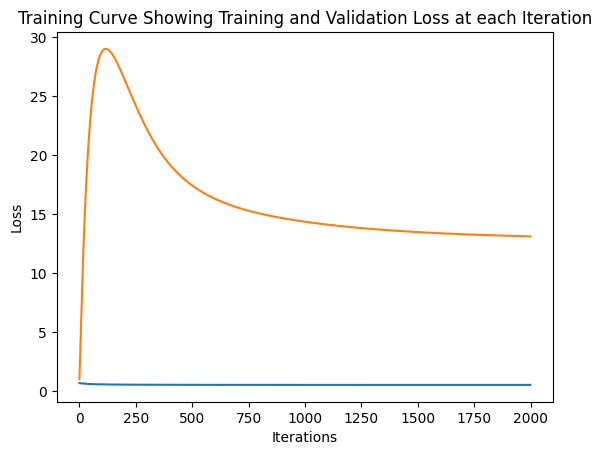

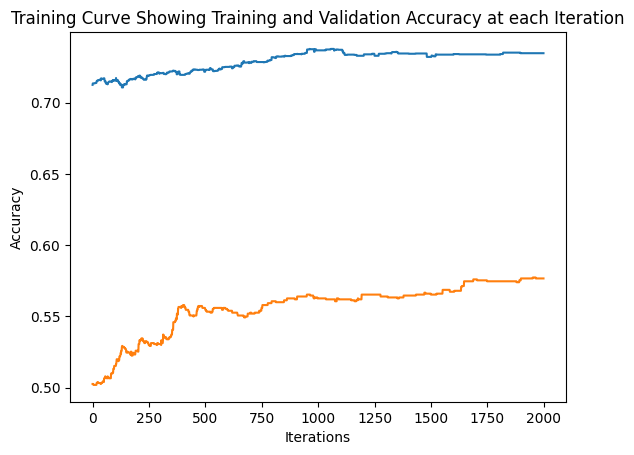

Final Training Loss: 0.5351184050647002
Final Validation Loss: 13.12694885113129
Final Training Accuracy: 0.7346
Final Validation Accuracy: 0.5766666666666667


array([-0.2020629 , -0.47101017, -0.19910755, -0.02309518,  0.05439568,
       -0.23674371,  1.50371243, -0.08522893,  0.95699853,  0.05220155,
       -0.05447941,  0.05209396, -0.07900302, -0.04351242, -0.37846805])

In [14]:
def solve_via_gradient_descent(alpha=0.0025, niter=1000,
                               X_train=X_train_norm, t_train=t_train,
                               X_valid=X_valid_norm, t_valid=t_valid,
                               w_init=None, plot=True):
    '''
    Given `alpha` - the learning rate
          `niter` - the number of iterations of gradient descent to run
          `X_train` - the data matrix to use for training
          `t_train` - the target vector to use for training
          `X_valid` - the data matrix to use for validation
          `t_valid` - the target vector to use for validation
          `w_init` - the initial `w` vector (if `None`, use a vector of all zeros)
          `plot` - whether to track statistics and plot the training curve

    Solves for logistic regression weights via full batch gradient descent.
    Return weights after `niter` iterations.
    '''
    # initialize all the weights to zeros
    w = np.zeros(X_train.shape[1])

    # we will track the loss and accuracy values at each iteration to record progress
    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []

    for it in range(niter):
        dw = grad(w, X_train, t_train)
        w = w - alpha * dw

        if plot:
            # Record the current training and validation loss values.
            train_loss.append(loss(w, X_train, t_train))
            valid_loss.append(loss(w, X_valid, t_valid))
            train_acc.append(accuracy(w, X_train, t_train))
            valid_acc.append(accuracy(w, X_valid, t_valid))

    if plot:
        plt.title("Training Curve Showing Training and Validation Loss at each Iteration")
        plt.plot(train_loss, label="Training Loss")
        plt.plot(valid_loss, label="Validation Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()

        plt.title("Training Curve Showing Training and Validation Accuracy at each Iteration")
        plt.plot(train_acc, label="Training Accuracy")
        plt.plot(valid_acc, label="Validation Accuracy")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.show()

        print("Final Training Loss:", train_loss[-1])
        print("Final Validation Loss:", valid_loss[-1])
        print("Final Training Accuracy:", train_acc[-1])
        print("Final Validation Accuracy:", valid_acc[-1])
    return w

solve_via_gradient_descent(alpha=0.05, X_train=X_train_norm, X_valid=X_valid_norm, niter=2000)

**Task** Run the below code, which shows that if we do not normalize our data, our model performance suffers significantly.

<ipython-input-13-9ed9d1227ad2>:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


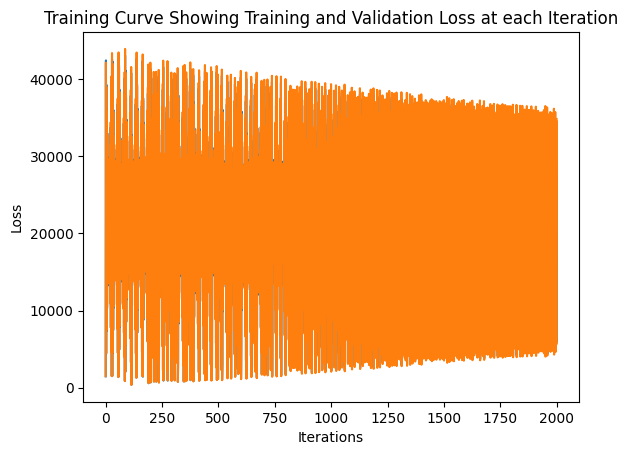

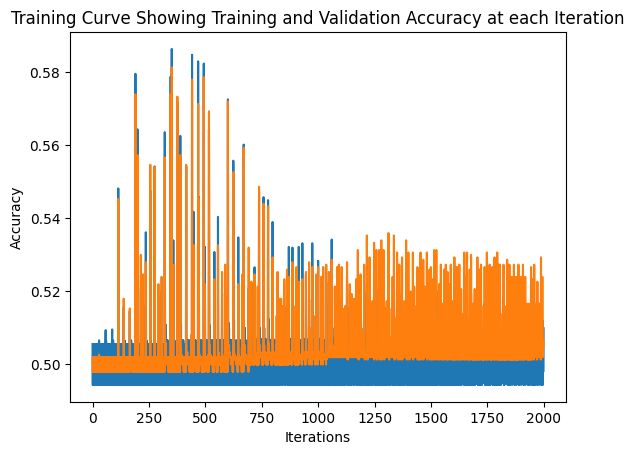

Final Training Loss: 34050.98668837243
Final Validation Loss: 34822.02956191307
Final Training Accuracy: 0.51
Final Validation Accuracy: 0.5053333333333333


array([ 1.04529780e-01, -2.37058503e+00, -1.71861437e+00,  2.61858499e+00,
        2.54662008e-01, -1.22379421e+00,  7.69242310e+00, -6.36833676e-01,
        2.47005526e+02,  1.26520257e+00,  1.53212209e+00,  3.12469598e+01,
        3.20581792e+00, -4.89698542e+01, -1.23875106e+01])

In [15]:
solve_via_gradient_descent(alpha=0.05, X_train=X_train, X_valid=X_valid, niter=2000)

## Part 3. Logistic Regression with Stochastic Gradient Descent

Full batch gradient descent has its merits, but it can consume a lot of resources in terms of time or memory. To mitigate this, let's try computing gradients over small samples of data at each iteration instead of over the full data set.  

**Graded Task**: Complete the function `solve_via_sgd`, which will use a mini-batch
to compute the gradient at each iteration instead of the full training data set.
In this function, take as parameter the number of *epochs* to train, and our *batch size*.

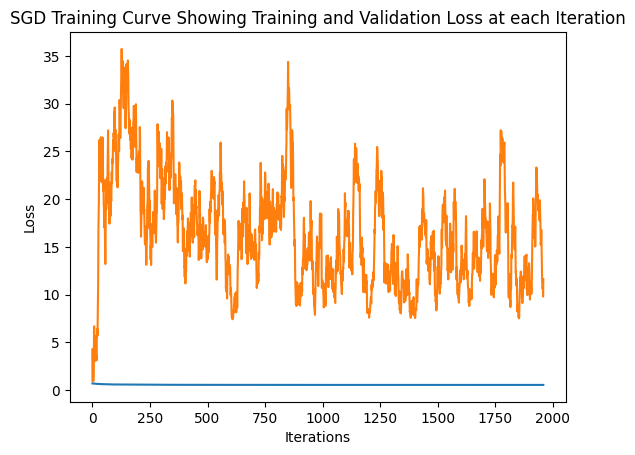

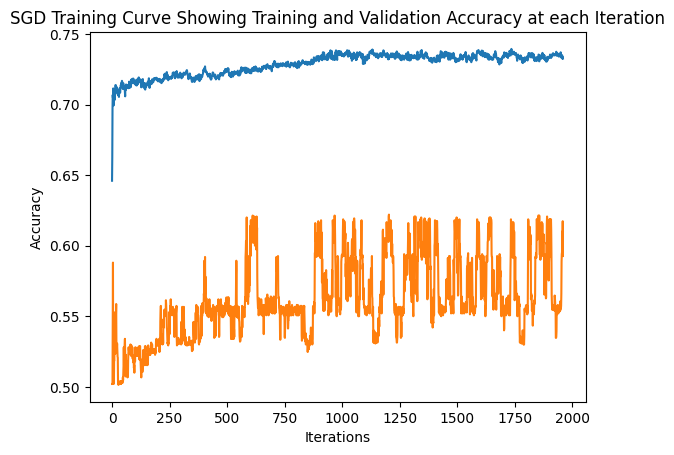

Final Training Loss: 0.5351360506355342
Final Validation Loss: 11.625491698955631
Final Training Accuracy: 0.7326
Final Validation Accuracy: 0.5926666666666667


array([-0.20321337, -0.47535214, -0.20074748, -0.02423282,  0.05462196,
       -0.23104056,  1.49938035, -0.08619815,  0.95272559,  0.05366175,
       -0.05658611,  0.05254243, -0.07561281, -0.04099566, -0.37551467])

In [16]:
import random

def solve_via_sgd(alpha=0.0025, n_epochs=0, batch_size=100,
                  X_train=X_train_norm, t_train=t_train,
                  X_valid=X_valid_norm, t_valid=t_valid,
                  w_init=None, plot=True):
    '''
    Given `alpha` - the learning rate
          `n_epochs` - the number of **epochs** of gradient descent to run
          `batch_size` - the size of ecach mini batch
          `X_train` - the data matrix to use for training
          `t_train` - the target vector to use for training
          `X_valid` - the data matrix to use for validation
          `t_valid` - the target vector to use for validation
          `w_init` - the initial `w` vector (if `None`, use a vector of all zeros)
          `plot` - whether to track statistics and plot the training curve

    Solves for logistic regression weights via stochastic gradient descent,
    using the provided batch_size.

    Return weights after `niter` iterations.
    '''
    # as before, initialize all the weights to zeros
    w = np.zeros(X_train.shape[1])

    # as before, track the loss and accuracy values at each iteration
    train_loss = [] # for the current minibatch
    valid_loss = [] # for the entire validation data set
    train_acc = []  # for the current minibatch
    valid_acc = []  # for the entire validation data set

    # track the number of iterations
    niter = 0

    # we will use these indices to help shuffle X_train
    N = X_train.shape[0] # number of training data points
    indices = list(range(N))

    for e in range(n_epochs):
        # Each epoch will iterate over the training data set exactly once.
        # At the beginning of each epoch, we need to shuffle the order of
        # data points in X_train. Since we do not want to modify the input
        # argument `X_train`, we will instead randomly shuffle the `indices`,
        # and we will use `indices` to iterate over the training data
        random.shuffle(indices)

        for i in range(0, N, batch_size):
            if (i + batch_size) >= N:
                # At the very end of an epoch, if there are not enough
                # data points to form an entire batch, then skip this batch
                continue

            # TODO: complete the below code to compute the gradient
            # only across the minibatch:
            indices_in_batch = indices[i: i+batch_size]
            X_minibatch = X_train[indices_in_batch] # TODO: subset of "X_train" containing only the
                               #       rows in indices_in_batch
            t_minibatch = t_train[indices_in_batch] # TODO: corresponding targets to X_minibatch
            y_minibatch = sigmoid(np.dot(X_minibatch, w))
            dw = np.dot(X_minibatch.T, (y_minibatch - t_minibatch)) / batch_size # TODO: gradient of the avg loss over the minibatch
            w = w - alpha * dw

            if plot:
                # Record the current training and validation loss values
                train_loss.append(loss(w, X_train, t_train))
                valid_loss.append(loss(w, X_valid, t_valid))
                train_acc.append(accuracy(w, X_train, t_train))
                valid_acc.append(accuracy(w, X_valid, t_valid))

    if plot:
        plt.title("SGD Training Curve Showing Training and Validation Loss at each Iteration")
        plt.plot(train_loss, label="Training Loss")
        plt.plot(valid_loss, label="Validation Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()

        plt.title("SGD Training Curve Showing Training and Validation Accuracy at each Iteration")
        plt.plot(train_acc, label="Training Accuracy")
        plt.plot(valid_acc, label="Validation Accuracy")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.show()

        print("Final Training Loss:", train_loss[-1])
        print("Final Validation Loss:", valid_loss[-1])
        print("Final Training Accuracy:", train_acc[-1])
        print("Final Validation Accuracy:", valid_acc[-1])
    return w

solve_via_sgd(alpha=0.05, X_train=X_train_norm, X_valid=X_valid_norm, n_epochs=40)

**Task:** You should see that although the final validation accuracy is about the same,
the training curve looks different. Explain why the SGD training curve is
more noisy than the full batch gradient descent training curve that you created above.

In [ ]:
# The SGD training curve is noisier because each iteration updates the weights using gradients computed from small mini-batches, introducing more variability in the update direction.

**Graded Task** Complete the following code, which compares the time it takes
to complete 40 epochs of training using SGD vs training for the same number of
*iterations* using full batch gradient descent. In the submission, include
your code, output, and explanation of why your SGD code runs *faster* than
our full batch gradient descent code.

In [18]:
import time

a = time.time()
solve_via_sgd(alpha=0.05, X_train=X_train_norm, X_valid=X_valid_norm, n_epochs=40, batch_size=50, plot=False)
b = time.time()
print("SGD Time:", b - a)

a = time.time()

# TODO: run `solve_via_gradient_descent` here with the same settings as our call
# to `solve_via_sgd`, with `plot=False` and an equivalent number of iterations.
solve_via_gradient_descent(alpha=0.05, X_train=X_train_norm, X_valid=X_valid_norm, niter=2000, plot=False)

b = time.time()

print("Full Batch GD Time:", b - a)
# If you do not get the desired results, make sure that your n_epochs
# and niter settings are set so that both SGD and and full batch GD
# are training for the **same number of iterations**. (Hint: How can
# you convert between itierations and epochs?)

SGD Time: 0.6965339183807373
Full Batch GD Time: 1.2918429374694824


In [ ]:
# TODO: Explanation of difference in runtime
# Please make sure that your explanation is not cut off in your PDF file
# SGD runs faster because it computes gradients using small mini-batches (e.g., size 50) instead of the entire dataset, reducing the computation per iteration. Although it typically requires more iterations to converge, the faster updates often lead to quicker overall convergence compared to full batch gradient descent, especially for large datasets.

## Part 4. Logistic Regression via `sklearn`

Coding algorithms from scratch can help us better understand that algorithm.
However, there are existing implementations of logistic regression, and a
very good one is in the package called sklearn. You can use sklearn's LogisticRegression
to fit logistic regression models using full batch gradient descent, and its SGDClassifiers
to fit logistic regression models using batch gradient descent. Note that we've not yet
discussed the concept of regularization in this class, which in theory would introduce
a "penalty" to a logistic regression's loss function.  As this is the case, we will
for the time being supply the following argument when we instantiate our LogisticRegression objects: penalty = 'none'.

**Task**: Run the code below, which fits the `LogisticRegression` model below using our data set.

You might also find the documentation for the `sklearn.linear_model.LogisticRegression` class helpful: [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [19]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(fit_intercept=False)

lr.fit(X_train_norm, t_train)

print(f"Training accuracy: {lr.score(X_train_norm, t_train)}")
print(f"Validation accuracy: {lr.score(X_valid_norm, t_valid)}")

Training accuracy: 0.7324
Validation accuracy: 0.5633333333333334


**Task**: Run the code below, which prints the coefficients (weights) you obtained from the Logistic Regression model.
What does a high value in a coefficient imply? What do coefficients close to zero imply?

In [20]:
list(zip(feature_names, lr.coef_[0]))

[('intercept', 0.20903532325886723),
 ('gender_female', -0.48141453057895156),
 ('re_hispanic', -0.6016559122764112),
 ('re_white', -0.42505529833919303),
 ('re_black', -0.3437381015009121),
 ('re_asian', -0.6856539860451281),
 ('chest_pain', 1.5262301184726086),
 ('drink_alcohol', -0.10791151039104088),
 ('age', 0.9618057712489709),
 ('blood_cholesterol', 0.05304072093867479),
 ('BMI', -0.05398433876529612),
 ('blood_pressure_sys', 0.05691288879343636),
 ('diastolic_bp', -0.08261023375021649),
 ('calories', -0.04507890450169111),
 ('family_income', -0.37412984010352457)]

## Part 5. Error Analysis

We often use accuracy as a go-to metric when evaluating the performance of classification model. But our accuracy measure weighs all errors equally, when in fact some errors may be associated with more serious impacts than others.  Mistakenly diagnosing a healthy individual as having heart disease, for example, may be less problematic than failing to diagnose an individual who potentially needs urgent care.  

To get a better sense of the errors that our classifier makes, we're going to do some work to investigate them.  We will loosely follow the testing recipe outlined by [Liu et. al.](https://www.thelancet.com/journals/landig/article/PIIS2589-7500(22)00003-6/fulltext#seccestitle40); this means we will explore our errors and then look at their distribution across sub-groups.  In addition, we will consider what we might do to equitably mitigate risks that are associated with our decision making.

To start our explorations, we'll look at the decisions we made well, i.e. the:

- True Positives (TP), or positive outcomes that were correctly predicted as positive.
- True Negatives (TN), or negative outcomes that were correctly predicted as negative.

Then we will look at our mistakes, i.e. the:

- False Positives (FP, or Type I errors), or negative outcomes that were predicted as positive. In our case, this occurs when our model predicts that a person has heart disease, but they do not.
- False Negatives (FN, or Type II errors), or positive outcomes that were predicted as negative. In our case, this occurs when our model predicts that a person does not have heart disease, but they do.

We can then use the metrics above to calculate:

- Precision (or True Positive Rate, or Positive Predictive Value): $\frac{TP}{TP + FP}$. This answers the question: out of all the examples that we predicted as positive, how many are really positive?
- Recall (or Sensitivity): $\frac{TP}{TP + FN}$. This answers the question: out of all the positive examples in the data set, how many did we predict as positive?
- False Positive Rate: $\frac{FP}{TN + FP}$.
- True Negative Rate (or Negative Predictive Value): $\frac{TN}{TN + FN}$. This answers the question: out of all the examples that we predicted as negative, how many are really negative?
]
A **confusion matrix** is a table that shows the number of TP, TN, FP, and FN, and a **receiver operating characteristic curve** (or ROC) shows how the True Positive Rate and False Positive Rate vary based on our choice of the decision making threshold used to binarize predictions.  By default, this threshold is 0.5, but it can be changed to any value between 0 and 1. Different thresholds will result in different TP and FP rates, all of which are illustrated on our graph. we can calculate the area underneath this curve in order to get a sense as to how our classifiers might work across a wide range of different thresholds. This calculation of area can also be used as a metric of our model's "goodness", and it is called AUC (or "Area Under Curve").

**Task:** Use the function `plot_confusion_matrix`, provided to you, to display
the confusion matrix over the test set.
You should see a similar number of False Positives as False Negatives.

Confusion Matrix:  [[241 151]
 [534 574]]
Accuracy:  0.5433333333333333
Precision:  0.6147959183673469
Recall:  0.3109677419354839


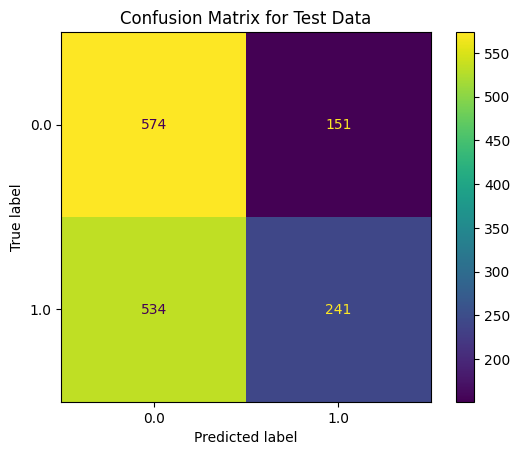

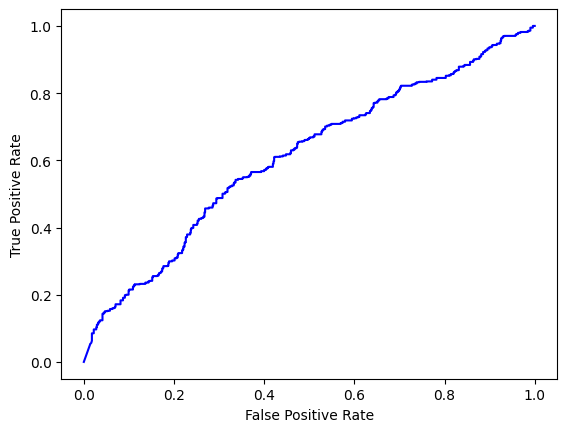

AUC for Test Data:  0.6100440489432702


In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

def plot_confusion_matrix(X, t, lr=lr, group = "Everyone"):
    """
    Use the sklearn model "lr" to make predictions for the data "X",
    then compare the prediction with the target "t" to plot the confusion matrix.

    Moreover, this function prints the accuracy, precision and recall
    """
    cm = confusion_matrix(t, lr.predict(X))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
    disp.plot()
    tn, fp, fn, tp = cm.ravel()
    print("Confusion Matrix: ", np.array([[tp, fp], [fn, tn]]))
    print("Accuracy: ", ((tp + tn) / (tp + fp + fn + tn)))
    print("Precision: ", (tp / (tp + fp)))
    print("Recall: ", (tp / (tp + fn)))
    plt.title(f"Confusion Matrix for {group}")

    plt.show()

def plot_roc_curve(X, t, lr=lr, color='r', group = "Everyone", plotflag=True):
    """
    Use the sklearn model "lr" to make un-thresholded predictions for the data "X",
    then generate an ROC curve to explore the impact of different thresholds on TP
    and FP rates.

    Moreover, calculate the "Area Under the Curve" (or AUC) to get a feel for the
    performance of our model across all possible classification thresholds. A model
    whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100%
    correct has an AUC of 1.0.
    """
    # use the model to predict un-thresholded values
    t_pred = lr.predict_proba(X)[::, 1]
    fpr, tpr, thresholds = roc_curve(t, t_pred)

    # plot the ROC curve
    plt.plot(fpr, tpr, color)
    if plotflag: #flag indicates if we want to plot now, or hold off so we can put more curves in one image!
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

    print(f"AUC for {group}: ", auc(fpr, tpr))

# TODO: call plot_confusion_matrix and plot_roc_curve here, on the test data
plot_confusion_matrix(X=X_test, t=t_test, lr=lr, group="Test Data")

plot_roc_curve(X=X_test, t=t_test, lr=lr, color='b', group="Test Data", plotflag=True)


Next, we will try to see if we can find any patterns or structures to our errors.
To do this, we will identify the examples where our predictions are wrong and observe
if anything about their features stands out. First, let's just plot the features of
our misclassified examples against those that were classified correctly.

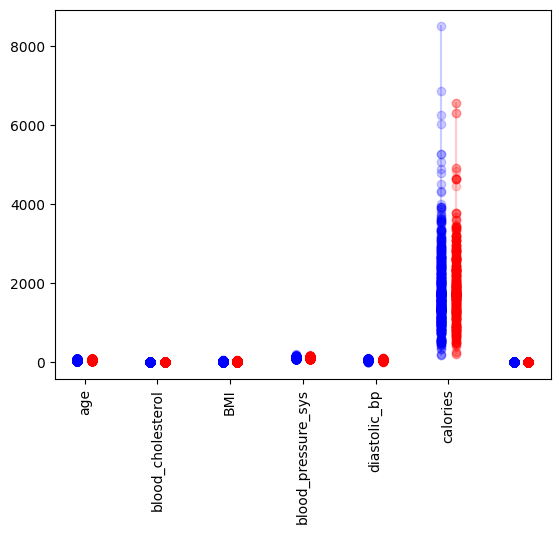

In [22]:
# extract the classes from our model
t_pred_prob = lr.predict_proba(X_test_norm)[::, 1]
t_pred = [1 if t > 0.5 else 0 for t in t_pred_prob]
diff = abs(t_pred - t_test)
errors = [i for i, n in enumerate(diff) if n == 1] # indices of incorrectly classified data points
correct = [i for i, n in enumerate(diff) if n == 0]# indices of correctly classified data points

feature_names = ["age", "blood_cholesterol", "BMI", "blood_pressure_sys", "diastolic_bp", "calories"]

for i in range(numerical_value_start,X_test_norm.shape[1]):
    # plot the normalized feature values of the correctly classified data points
    plt.plot(np.ones(X_test_norm[correct,i].shape)*(i-numerical_value_start)-0.1,
             X_test_norm[correct,i], color='b', marker='o', alpha=0.2)
    # plot the normalized feature values of the incorrectly classified data points
    plt.plot(np.ones(X_test_norm[errors,i].shape)*(i-numerical_value_start)+0.1,
             X_test_norm[errors,i], color='r', marker='o', alpha=0.2)

plt.xticks(list(range(0,6)), feature_names, rotation='vertical')

plt.show()

The distributions look comparable, but there may be a small collection of outliers with respect to 'BMI' and/or high systolic blood pressure who were misclassified. Some of these individual examples might warrant a closer look. Perhaps there is something about these individuals that compromised estimates due to BMI?  Note that many of these features will of course co-vary, and the way they co-vary can be revealing as well.  Later on in this course, we will look at tools and techniques to look for emergent patterns in ways that are sensitive to covariance. We could in theory use any patterns we discover in our errors to both inform and improve our model.

But for now, we are going to move on to explore error rates as they relate to groups that may vulnerable to inequitable health outcomes, like women, people of color or people who are poor.  To do this, we will stratify, or group, the errors in our predictions as they relate to groups of interest.  Note, of course, that our ability to group people in any way depends on how they have been identified in our data! Our understanding of how to categorize "identity" changes with place and time. This is a limitation that we will need to keep in mind, and about which we will need to be transparent when we report on our analyses.

While there are many groups that we may consider vulnerable, for the moment we will focus on **gender**
However, we encourage you to explore distributions of errors as they might relate to other potentially
vulnerable subgroups, like people of color or people without means.

**Graded Task:** Use the functions `plot_confusion_matrix` and `plot_roc_curve` to plot a confusion matrix for *only data points in the test set with GENDER=MALE*. Then, plot a confusion matrix for *only data points in the test set with GENDER=FEMALE*.

Confusion Matrix:  [[134  54]
 [289 273]]
Accuracy:  0.5426666666666666
Precision:  0.7127659574468085
Recall:  0.31678486997635935


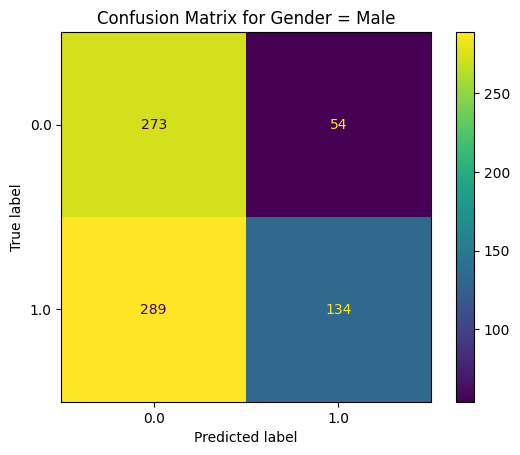

In [24]:
male = X_test_norm[:, 1] == 0 # identify rows with SEX=Male
# TODO: call plot_confusion_matrix here, on the test data
X_test_male = X_test_norm[male]
t_test_male = t_test[male]

plot_confusion_matrix(X=X_test_male, t=t_test_male, lr=lr, group="Gender = Male")

Confusion Matrix:  [[107  97]
 [245 301]]
Accuracy:  0.544
Precision:  0.5245098039215687
Recall:  0.3039772727272727


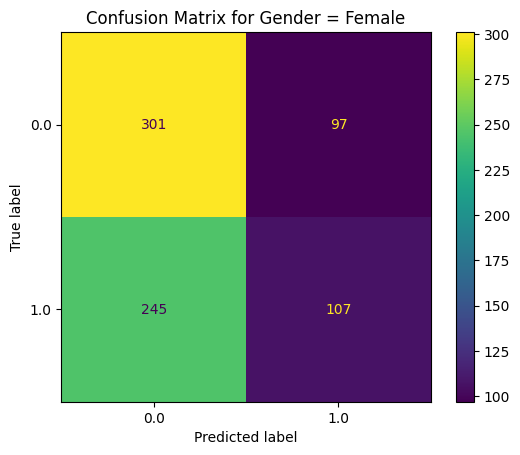

In [25]:
female = X_test_norm[:, 1] == 1 # identify rows with GENDER=Female
# TODO: call plot_confusion_matrix here, on the test data
X_test_female = X_test_norm[female]
t_test_female = t_test[female]

plot_confusion_matrix(X=X_test_female, t=t_test_female, lr=lr, group="Gender = Female")


**Graded Task**: The confusion matrices above should reveal two different distributions of errors!
Explain what differences you see, and why these differences are concerning.

In [ ]:
# The confusion matrices reveal that for males, the model has a higher false negative rate (289) compared to true positives, leading to poor recall (31%). For females, the model shows a higher false positive rate (97) and low precision (52%), indicating frequent incorrect positive predictions. These differences suggest gender-based prediction bias, which can cause unfair outcomes and require model adjustments for equity.

Finally, let's consider how we might relate what we have learned so far to decision making risk.  Assume that we are working with a medical team that is willing to sacrifice some precision in favour of sensitivity.  They feel that failing to identify individuals with heart disease is more risky than falsely identifying individuals who may be healthy. In addition, the team wants to guarantee a consistent sensitivity across both women and men.  They have decided they would like to enforce a fixed True Positive Rate of 80%, and this should be the same for everyone regardless of their gender.

We will start by looking at an ROC curve for the men in our dataset versus women.

In [26]:
plt.show()

Now, let's locate two classification thresholds (one for men and one for women) that are both associated with a fixed True Positive Rate of 80%. What are these thresholds, and what are the associated False Positive Rates for each sub-group?

In [27]:
t_pred = lr.predict_proba(X_test_norm[female])[::, 1]
fpr, tpr, thresholds = roc_curve(t_test[female], t_pred)
idx = (np.abs(tpr - 0.8)).argmin()
best_threshold = thresholds[idx]
best_fpr = fpr[idx]
print('FPR is %f and TPR is %f when category is FEMALE and threshold is %f' % (fpr[idx], tpr[idx], best_threshold))

t_pred = lr.predict_proba(X_test_norm[male])[::, 1]
fpr, tpr, thresholds = roc_curve(t_test[male], t_pred)
idx = (np.abs(tpr - 0.8)).argmin()
best_threshold = thresholds[idx]
best_fpr = fpr[idx]
print('FPR is %f and TPR is %f when category is MALE and threshold is %f' % (fpr[idx], tpr[idx], best_threshold))

FPR is 0.768844 and TPR is 0.798295 when category is FEMALE and threshold is 0.000000
FPR is 0.654434 and TPR is 0.799054 when category is MALE and threshold is 0.000000


**Task**:
Assuming you adjusted your classifications to ensure the same sensitivity across groups, would you be willing to use your classifier to predict heart disease?  Are there metrics you can think of that might convince you that your classifications were both accurate and ... safe?

In [ ]:
# By monitoring these metrics and ensuring balanced performance across groups, the classifier could be more trusted for sensitive applications like predicting heart disease.